In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from collections import Counter
import numpy as np

In [3]:
# Load dataset
raw_data = pd.read_csv('bank-full.csv', delimiter=';')
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
data = raw_data.copy()

In [6]:
# Target column (binary classification: "yes" -> 1, "no" -> 0)
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Drop unnecessary columns
data.drop(columns=['contact', 'poutcome', 'day', 'month'], inplace=True)


In [7]:
# Show missing values summary
missing_summary = data.isna().sum()
print("Missing values in each column:\n", missing_summary)

Missing values in each column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64


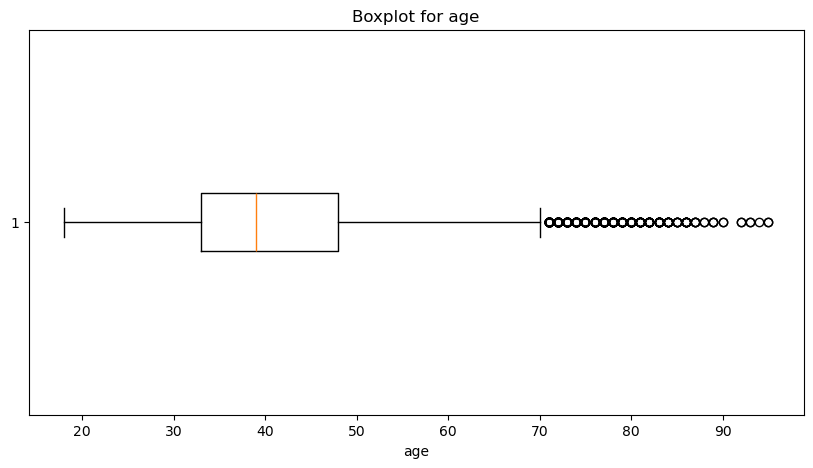

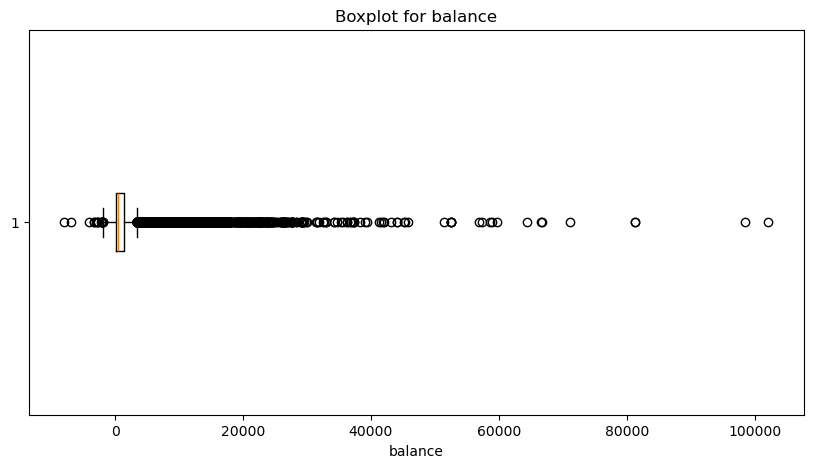

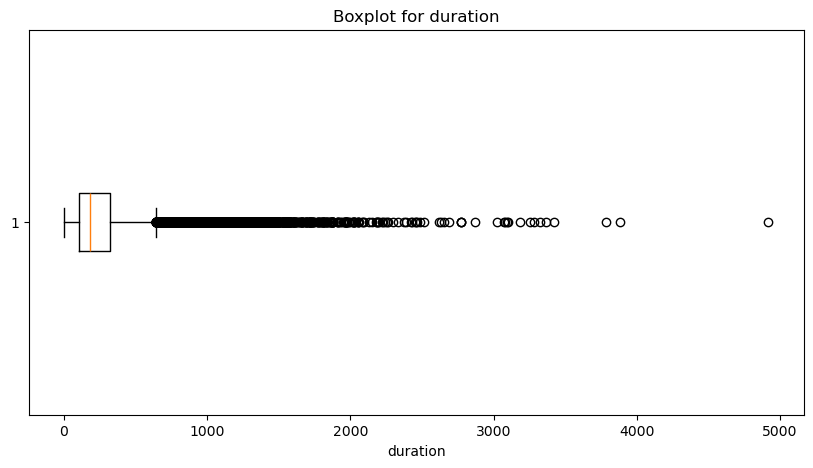

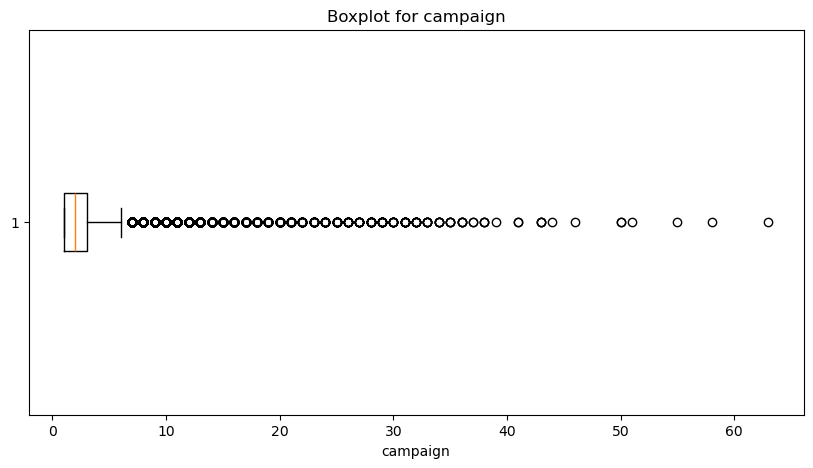

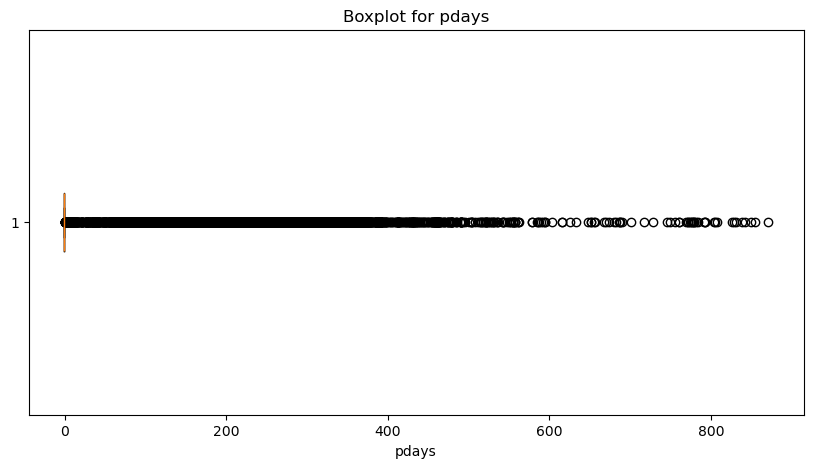

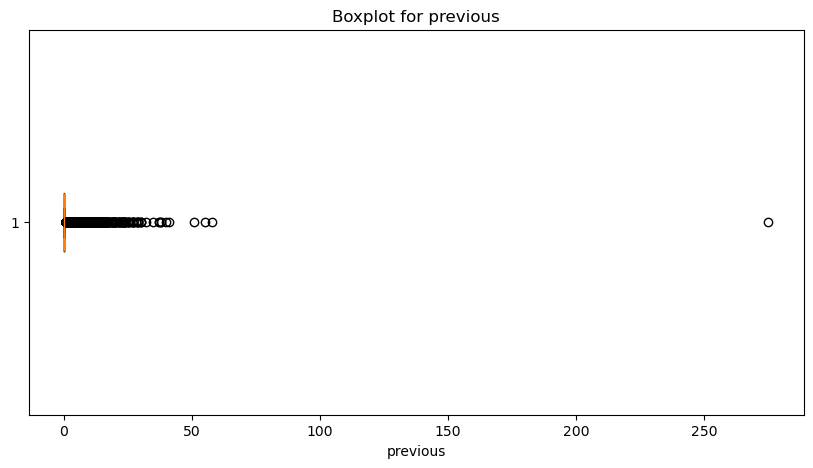

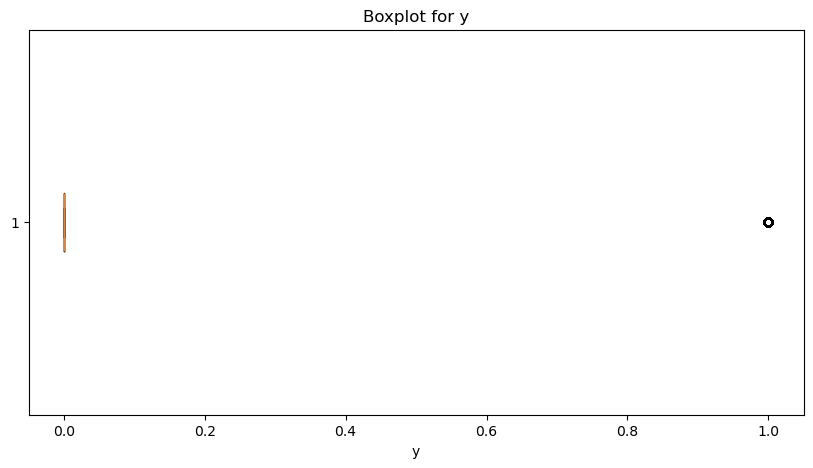

In [8]:
# Visualize numerical columns for outliers
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(data[col], vert=False)
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()

In [9]:
# Handle outliers using Winsorization for balance, duration, and campaign
for col in ['balance', 'duration', 'campaign']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

In [10]:
# Feature Engineering
# 1. Create contact rate
data['contact_rate'] = data['campaign'] / (data['previous'] + 1)

# 2. Create is_recontacted binary feature
data['is_recontacted'] = (data['pdays'] > 0).astype(int)

# 3. Create balance categories
data['balance_category'] = pd.cut(data['balance'], bins=[-float('inf'), 0, 500, 1500, float('inf')], 
                                  labels=['low', 'medium', 'high', 'very_high'])

# 4. Create age group categories
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 100], labels=['young', 'middle-aged', 'senior'])

# 5. Create is_long_call binary feature
data['is_long_call'] = (data['duration'] > 300).astype(int)

In [11]:
data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,contact_rate,is_recontacted,balance_category,age_group,is_long_call
0,58,management,married,tertiary,no,2143.0,yes,no,261,1,-1,0,0,1.0,0,very_high,senior,0
1,44,technician,single,secondary,no,29.0,yes,no,151,1,-1,0,0,1.0,0,medium,middle-aged,0
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,76,1,-1,0,0,1.0,0,medium,middle-aged,0
3,47,blue-collar,married,unknown,no,1506.0,yes,no,92,1,-1,0,0,1.0,0,very_high,middle-aged,0
4,33,unknown,single,unknown,no,1.0,no,no,198,1,-1,0,0,1.0,0,medium,middle-aged,0


/tmp/ipykernel_795/255489888.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


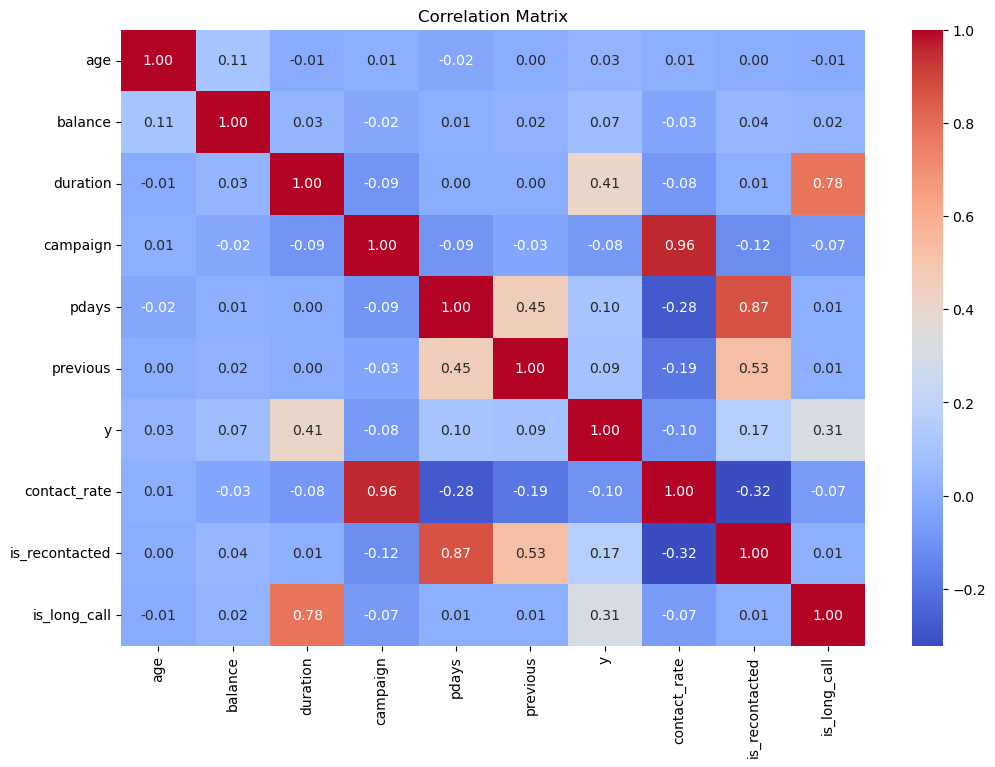

In [12]:
# Correlation matrix analysis
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Separate features and target
X = data.drop(columns=['y'])
y = data['y']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [14]:
# Preprocessing for numerical data
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Preprocessing for categorical data
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_encoded = encoder.fit_transform(X[categorical_columns])

# Create a DataFrame for the encoded categorical data
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=X.index)

# Combine numerical and categorical data
X_preprocessed = pd.concat([X[numerical_columns], categorical_encoded_df], axis=1)

In [15]:
# Step 1: Feature Selection using SelectKBest
print("Performing Feature Selection...")
kbest_selector = SelectKBest(score_func=mutual_info_classif, k=20)  # Select top 20 features
X_selected = kbest_selector.fit_transform(X_preprocessed, y)
selected_features = kbest_selector.get_support(indices=True)
print("Selected Features Indices:", selected_features)

Performing Feature Selection...
Selected Features Indices: [ 0  1  2  3  4  5  6  7  8 10 17 22 23 25 26 28 29 30 31 32]


In [16]:
# Step 2: Apply PCA for Dimensionality Reduction
print("Applying PCA...")
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_pca = pca.fit_transform(X_selected)
print("PCA reduced dimensions to:", X_pca.shape[1])

Applying PCA...
PCA reduced dimensions to: 11


In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [18]:
print("Training data shape before balancing:", X_train.shape)
print("Testing data shape before balancing:", X_test.shape)

Training data shape before balancing: (36168, 11)
Testing data shape before balancing: (9043, 11)


In [19]:
# Ask user to choose the method for handling imbalance
method = input("Choose method for handling class imbalance (SMOTE/undersample): ").strip().lower()

#method = 'smote'
#method = 'undersample'

if method == 'smote':
    print("Original class distribution:", Counter(y_train))
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("Balanced class distribution with SMOTE:", Counter(y_train_balanced))

elif method == 'undersample':
    print("Original class distribution:", Counter(y_train))
    undersampler = RandomUnderSampler(random_state=42)
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)
    print("Balanced class distribution with undersampling:", Counter(y_train_balanced))

else:
    print("Invalid input. Proceeding with original data.")
    X_train_balanced, y_train_balanced = X_train, y_train

# Output preprocessed shapes
print("Training data shape after balancing:", X_train_balanced.shape)
print("Testing data shape:", X_test.shape)

Choose method for handling class imbalance (SMOTE/undersample): smote
Original class distribution: Counter({0: 31970, 1: 4198})
Balanced class distribution with SMOTE: Counter({0: 31970, 1: 31970})
Training data shape after balancing: (63940, 11)
Testing data shape: (9043, 11)


In [20]:
# Model training and evaluation with hyperparameter tuning
hyperparameters = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None]
    },
    "Gradient Boosting": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200]
    }
}

In [21]:
# Model training and evaluation
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Ask user to select a model
print("Available models:")
for model_name in models.keys():
    print(f"- {model_name}")
selected_model_name = input("Choose a model for training and evaluation: ").strip()

if selected_model_name not in models:
    print("Invalid model selection. Please run the code again and choose a valid model.")
else:
    model = models[selected_model_name]
    print(f"\nTraining {selected_model_name} with Hyperparameter Tuning...")
    
    # Calculate the total number of parameter combinations
    param_combinations = len(list(product(*hyperparameters[selected_model_name].values())))
    n_iter = min(10, param_combinations)  # Adjust n_iter to the total combinations or 10, whichever is smaller

    random_search = RandomizedSearchCV(model, hyperparameters[selected_model_name], scoring='roc_auc', cv=5, n_iter=n_iter, random_state=42, n_jobs=-1)
    random_search.fit(X_train_balanced, y_train_balanced)

    # Predictions using the best-tuned model
    y_pred = random_search.best_estimator_.predict(X_test)
    y_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]

    print(f"{selected_model_name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # AUC Metric
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")


Available models:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
Choose a model for training and evaluation: Logistic Regression

Training Logistic Regression with Hyperparameter Tuning...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      7952
           1       0.35      0.76      0.48      1091

    accuracy                           0.80      9043
   macro avg       0.66      0.78      0.68      9043
weighted avg       0.89      0.80      0.83      9043

Accuracy: 0.8012
AUC Score: 0.8675
